# Install libraly

In [0]:
# for use BigQuery API you need upgrade packages and then install required libraly
# Common Protos are common dependencies throughout the Google API ecosystem, and which are made available for use as dependencies elsewhere as BigQuery.
! pip3 install --upgrade googleapis-common-protos

! pip3 install google-cloud-bigquery-storage
! pip3 install pyarrow
! pip3 install fastavro


In [0]:
# for created interactive visualisation
! pip install plotly # We need install Plotly before Cufflinks
! pip install cufflinks

In [0]:
!pip show google-cloud-bigquery-storage


# for dependens
! pip3 freeze > requirements.txt

# Imports and settings by visual

In [0]:
# print all output in cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
import pandas as pd
import cufflinks as cf
import pandas_profiling
import numpy as np
from google.oauth2 import service_account
from google.cloud import *
import scipy.stats as sc
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [0]:
# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [0]:
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [0]:
# logging need for check loading progress
import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

# Define credintial and ID project

In [0]:
# initial project
project_id_3='bionic-tracer-254818'
project_id_2='sqlbig'
project_id='sotf-265920'

In [0]:
# get credentianls and Authenticating with a Service Account
credentials = service_account.Credentials.from_service_account_file(
    'sotf-265920-2def50409aef.json')
credentials_2 = service_account.Credentials.from_service_account_file(
    'sqlbig-aa81296ac0f5.json')
credentials_3 = service_account.Credentials.from_service_account_file(
    'bionic-tracer-254818-38d6dd6ee2db.json')

# *SET query and load data use API*

In [0]:
query_tst = """
SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
"""

In [0]:
df_iq_retail = pd.read_gbq(query_tst, 
                 project_id=project_id, 
                 credentials=credentials,   
                use_bqstorage_api=True,    
              configuration = {'query': {'allowLargeResult': True}}, 
                  dialect='standard')

Requesting query... 
Query running...
Job ID: 9e650475-427c-4752-9eae-8ab630fbba63
Query done.
Cache hit.

Got 17735173 rows.

Total time taken 305.06 s.
Finished at 2020-02-02 18:34:04.


# **CLEAR** **DATA**

The number of unique country code for the county number is 109, and the unique country code for the country itself is 201. The column describing the country has inherent duplication due to a different register (ex. Polk - 125541 POLK - 53821) is perceived as two different countries - lead to the same register.

---

К-сво уникальных кодов стран county number - 109, а самих уникальных стран country - 201. Колонке с описанием страны присущее дублирование за счет разного регистра (ex. polk - 125541 POLK - 53821) воспринимается как две разные страны - привести к одному регистру.



In [0]:
# приведение к одному регистру
df_iq_retail['county'] = df_iq_retail['county'].str.lower()
df_iq_retail['address'] = df_iq_retail['address'].str.lower()
df_iq_retail['city'] = df_iq_retail['city'].str.lower()
df_iq_retail['category_name'] = df_iq_retail['category_name'].str.lower()
df_iq_retail['vendor_name'] = df_iq_retail['vendor_name'].str.lower()
df_iq_retail['item_description'] = df_iq_retail['item_description'].str.lower()
df_iq_retail['store_name'] = df_iq_retail['store_name'].str.lower()

In [0]:
# check on unique value
print(df_iq_retail['county'].drop_duplicates().count())
print(df_iq_retail['county_number'].drop_duplicates().count())

In [0]:
#не бъются к-ство category и category name = distinct 84 vs 80
print(df_iq_retail['category'].drop_duplicates().count())
print(df_iq_retail['category_name'].drop_duplicates().count())

# Missing values

Missing values are fine when we do Exploratory Data Analysis, but they will have to be filled in for machine learning methods.

## TODO:
* Есть названия и коды всех магазинов, но при этом к-ство пропущеных адрессов около трёх тысяч. Есть ли магазины с кодом, но без адреса, могу ли по ним заполнить пропуски?
* При построении аналитики по странам - говорить, что у выборку не вошли только 0.8% от общего к-тсва данных по продажам (наны)  
* не бъются к-ство category и category name = distinct 84 vs 80 
* к-ство кодов item_number продуктов больше, чем их расшифоровок item_description = 3605 va 3406. могу ли заполнить 
* item_number - какие позиции покупают вместе?
* 


# Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an open-ended process where we make plots and calculate statistics in order to explore our data. The purpose is to to find anomalies, patterns, trends, or relationships. These may be interesting by themselves (for example finding a correlation between two variables) or they can be used to inform modeling decisions such as which features to use. In short, the goal of EDA is to determine what our data can tell us! EDA generally starts out with a high-level overview, and then narrows in to specific parts of the dataset once as we find interesting areas to examine.

# Generate report for data set use libraly 
[*pandas-profiling*](https://github.com/pandas-profiling/pandas-profiling) 


In [0]:
#profile = pandas_profiling.ProfileReport(df_iq_retail)
#profile.to_file(outputfile="IOWA_liquer_data_profiling_1.html")
pandas_profiling.ProfileReport(df_iq_retail).to_file(outputfile="IOWA_liquer_data_profiling_1.html")

You know that you are dealing  with categorical (14) and numerical (6) data. 


> *Numerical* variables can be used to extract many different measurements such as the mean, standard deviation, etc.

> *Categorical* variables are generally an interesting way of segmenting and grouping the data.



In [0]:
cat_cols = ['Product_Fat_Content','Product_Type',
            'Supermarket _Size', 'Supermarket_Location_Type',
           'Supermarket_Type' ]

num_cols = ['Product_Weight', 'Product_Shelf_Visibility',
            'Product_Price', 'Supermarket_Opening_Year', 'Product_Supermarket_Sales']

# **DATA VISUALIZATION**

# **Scatter plot for Numerical Features**

In [0]:
for col in num_cols:
    fig = plt.figure(figsize=(6,6)) # define plot area
    ax = fig.gca() # define axis  

    newdata.plot.scatter(x = col, y = 'Product_Supermarket_Sales', ax = ax)

# **PAIR PLOT OF COLUMNS WITHOUT MISSING VALUES**

In [0]:
# exclude missing category

cat_cols_pair = ['category_name','vendor_name','item_description' ]

cols_2_pair = ['Product_Fat_Content',
             'Product_Shelf_Visibility',
             'Product_Type',
             'Product_Price',
             'Supermarket_Opening_Year',
             'Supermarket_Location_Type',
             'Supermarket_Type',
             'Product_Supermarket_Sales']

for col in cat_cols_pair:
    sns.set()
    plt.figure()
    sns.pairplot(newdata[cols_2_pair], height=3.0, hue=col)
    plt.show()

# Univariate Outlier treatment

Many algorithms are sensitive to the range and distribution of attribute values in the input data. Outliers in input data can skew and mislead the results and make results less reliable, that's why we have to recognize all the outliers and treat them -  is called *IQR score technique*.

*   bottles_sold - (γ1 = 55.414) Skewed
*   sale_dollars - (γ1 = 75.021) Skewed
*   volume_sold_liters - (γ1 = 56.305) Skewed
*   bottle_volume_ml - (γ1 = 244.73) Skewed
*   state_bottle_cost - (γ1 = 246.65) Skewed

In [0]:
%matplotlib inline
matplotlib.style.use('ggplot')

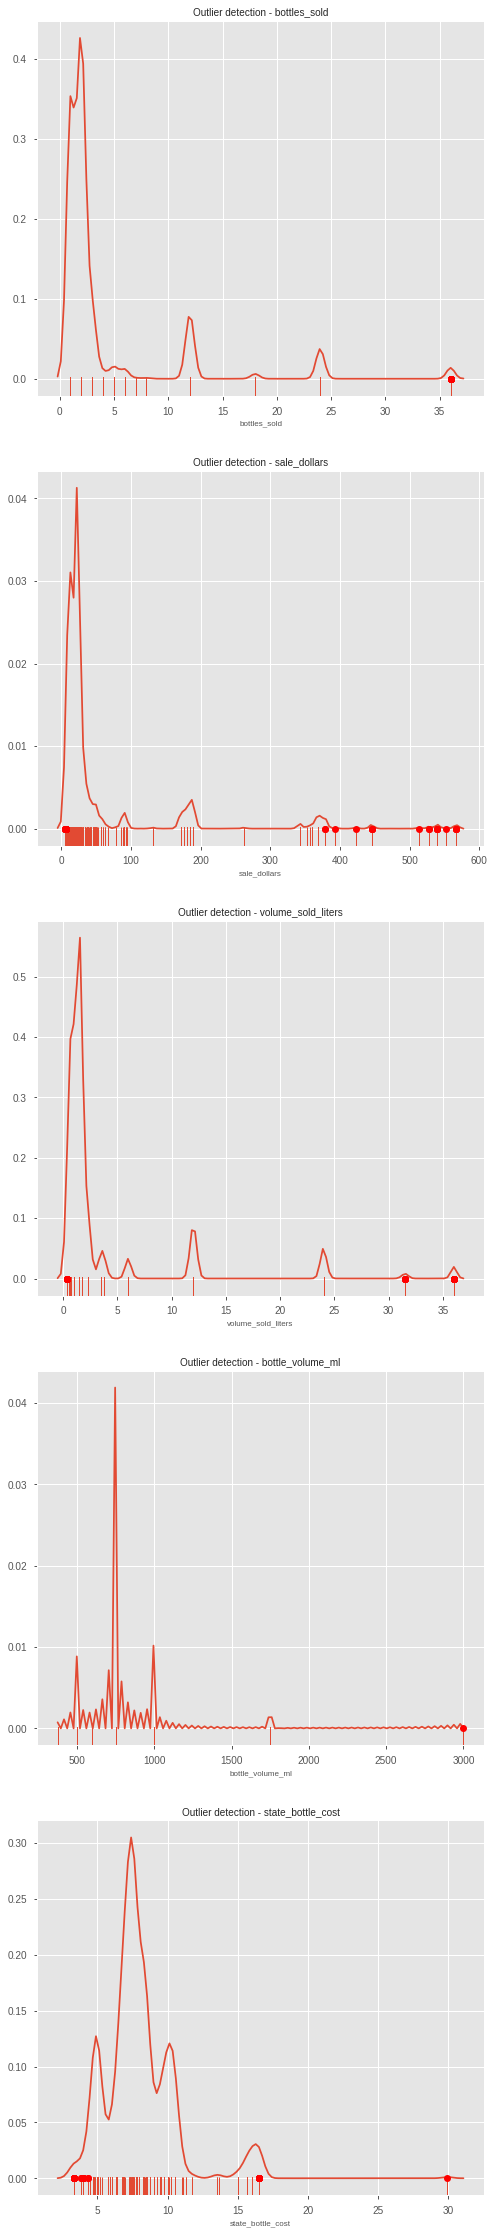

In [0]:
# Percentile based outlier removal 
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)


col_names = ['bottles_sold','sale_dollars', 'volume_sold_liters', 'bottle_volume_ml', 'state_bottle_cost']

fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
    x = df_iq_retail[col_val][:1000]
    sns.distplot(x, ax=ax[i], rug=True, hist=False)
    outliers = x[percentile_based_outlier(x)]
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    ax[i].set_title('Outlier detection - '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    
plt.show()

# Numeric Variable
Plots with a kernel density estimate and histogram with bin size determined automatically

In [0]:
col_names = [ 'store_number', 'county_number', 
             'category', 'vendor_number',
              'item_number',  'pack',       
   'bottle_volume_ml' ,  'bottles_sold', 
  'state_bottle_cost', 'state_bottle_retail', # state_bottle_retail is highly correlated with state_bottle_cost
  'sale_dollars',  'volume_sold_liters']

fig, ax = plt.subplots(len(col_names), figsize=(16,12))

for i, col_val in enumerate(col_names):
        
    sns.distplot(df_iq_retail[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)
    
plt.show()

# Univariate outlier detection
To analysis the outliers in the numeric features of the dataset

# Обследование распределения данных


---
Наиболее часто используются следующие виды диаграмм: коробчатая диаграмма (или ящик с усами) и гистограммы. 
Ящик с усами － удобное компактное представление о выборке, позволяет на одном изображении увидеть несколько исследуемых признаков, а значит, сравнить их друг с другом. Иначе этот вид графика называется диаграмма размаха (англ. box-and-whiskers diagram or plot, box plot). Такой вид диаграммы в понятной форме показывает медиану (или, если нужно, среднее), нижний и верхний квартили, минимальное и максимальное значение выборки и выбросы. Несколько таких ящиков можно нарисовать бок о бок, чтобы визуально сравнивать одно распределение с другим; их можно располагать как горизонтально, так и вертикально. Расстояния между различными частями ящика позволяют определить степень разброса (дисперсии), асимметрии данных и выявить выбросы.



In [0]:
col_names = [ 'store_number', 'county_number', 
             'category', 'vendor_number',
              'item_number',  'pack',       
   'bottle_volume_ml' ,  'bottles_sold', 
  'state_bottle_cost', 'state_bottle_retail', # state_bottle_retail is highly correlated with state_bottle_cost
  'sale_dollars',  'volume_sold_liters']

fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
        
    sns.boxplot(y=df_iq_retail[col_val], ax=ax[i])
    ax[i].set_title('Box plot - '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    
plt.show()

# **Корреляция**

Cпирмена (норм. распред, линейная связь - график рассеяния, точечная ) - не парметрическая. 
Пирсона (монотонная связь - падение или возрастание, без перегибов).


---
Наблюдается высокая кореляция для:

1.   state_bottle_retail is highly correlated with state_bottle_cost (ρ = 0.99993) 
2.   volume_sold_gallons is highly correlated with volume_sold_liters (ρ = 1)  - один и тот же показатель, но в разных единицах измерения
3.    volume_sold_liters is highly correlated with bottles_sold (ρ = 0.94871) - поскольку бутылка имеет зависимую х-ку объем, чем больше объем, тем выше стоимость.

Степень корреляции:


*   *сильная положительная корреляция* о зависимости - увеличение-увеличение (уменьшение-уменьшение) для ...............
*   *сильная негативная корреляция* о зависимости увеличение-уменьшение (уменьшение-увеличение) для ...............


*!!!!!!!ОПИСАТЬ два графика по корреляции с репорта*

**PACK**


---
Q1 - 6
Median	- 12
Mean	12.288
Q3 - 12
Медиана и 3 квартиль (не больше 75% покупок)  указывают на наиболее ходовую упаковку - 12 шт. 
Медиана и средне почти на одном уровне, но не равны - распределение не нормальное.

стандартное отклонение = **7.6167** свидет. о сильной рассеянности ряда значений относительно среднего. 


**BOTTLE VOLUME ML**


---
Q1 -	750
Median -	750
Mean	918.74
Q3 - 1000
Распределение не нормальное. 
Второй квартиль (меньше 25% покупок) и медиана указывают на объем покупок - 750 мл. Больше 75 % - выбирают 1000 мл.

стандарное отклонение - очень сильная рассеянность значений объема бутылки 677.12
коеф. вариации Coef of variation -	0.73701 при планировании указывает на большую изменчивость попыта на объем бутилки. НО необходимо проследить категорию товара (крепкий алкоголь, вино, шампанское и т.д.)! 


**Анализ временных рядов.**


---
Для каждого года создается блок с усами и выстраивается в ряд для непосредственного сравнения.
В течение некоторого интервала это может помочь определить выбросы (точки выше или ниже усов).
Через определенные промежутки времени, в данном случае, годы, мы можем искать многолетние тренды, сезонность и другую структурную информацию, которую можно смоделировать.

In [0]:
# по году распределение. 

groups = df_iq_retail['date'].groupby(TimeGrouper('A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.plot(subplots=True, legend=False)
pyplot.show()

Мы также можем быть заинтересованы в распределении значений по месяцам в течение года.
Выбираем один год 

[link text](https://miro.medium.com/max/533/0*NDKhtpZ5smbeyzku.)

In [0]:
# Потом взять год с выбросами и проанализировать внутри месяца. Аналогично с последним закрытым годом (2019)

one_year = df_iq_retail['date']['2019']
groups = one_year.groupby(TimeGrouper('M'))
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(1,13)
months.boxplot()
pyplot.show()

In [0]:
# функция для визуализации выручки по странам
def scatterplot(x_data, y_data, x_label="", y_label="", title="", color = "r", yscale_log=False):

    # Create the plot object
    _, ax = plt.subplots()

    # Plot the data, set the size (s), color and transparency (alpha)
    # of the points
    ax.scatter(x_data, y_data, s = 10, color = color, alpha = 0.75)

    if yscale_log == True:
        ax.set_yscale('log')

    # Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

Топ-10 магазинов по транзакциям. КАК они распределяются по годам? какой объем выручки?

In [0]:
# для отрисовки магазинов 

[ 'store_number', 'county_number', 
             'category', 'vendor_number',
              'item_number',  'pack',       
   'bottle_volume_ml' ,  'bottles_sold', 
  'state_bottle_cost', 'state_bottle_retail', # state_bottle_retail is highly correlated with state_bottle_cost
  'sale_dollars',  'volume_sold_liters']

top_stores = ['date', 'store_name', 'item_description']
names = top_stores.groupby('item_description', as_index=False).sum().sort_values('count', ascending=False)
names.head(10)

# **Цель определить топовые и плохо продаваемые позиции.**

# *XYZ-анализ*

Основная идея XYZ-анализа состоит в группи­ровании объектов по однородности анализи­руемых параметров, другими словами - по коэффициенту вариации.
определеить коеф. вариации по каждому товару

периодичность: месяц - т.к. мы не располагаем данными о переодичностb обновляемости товаров

In [0]:
# add new column to analyze by 
df_iq_retail['month_year'] = df_iq_retail['date'].dt.to_period('M')
df_iq_retail['year'] = df_iq_retail['date'].dt.to_period('Y')



In [0]:
# сет за последний год
df_iq_retail_last_y = df_iq_retail[df_iq_retail['year']=='2019']

In [0]:
# сводная таблица по каждому продукту
df_iq_retail_last_y.pivot_table(index='item_number', columns='month_year',
								aggfunc={'bottle_volume_ml':sum, 'state_bottle_retail':sum, 'pack':count})

**Вывод. **Товары групп А и В ???????????????? обеспечивают основной товарооборот компании. Поэтому необходимо обеспечивать постоянное их наличие. Обще­принятой является практика, когда по товарам группы А создается избыточный страховой за­пас, а по товарам группы В - достаточный.

volume_sold_gallons is highly correlated with volume_sold_liters (ρ = 1) Rejected
state_bottle_retail is highly correlated with state_bottle_cost (ρ = 0.99997) Rejected

так же можно прослеживать, какие наборы продуктов чаще всего покупают вместе? нужно для рекомендаций

# Iowa Liquor Sales by Year

In [0]:
sales_df = df_iq_retail[['year', 'state_bottle_retail', 'volume_sold_liters']]
 
sales_df.groupby('year').sum().plot(kind='bar', rot=45) #plot(kind='bar', rot=45)

Гипотезы для проверки:

1. Гипотеза влияния места расположения магазина (социально-демографический фактор). Клас магазина (ориентирован на  масс-маркет или премиум сегмент) и товарный ассортимент в нём. 
2. Гипотеза влияния дня недели на объем продаж.
3. Данные по персоналу, который работает в данном магазине (метрика удовлетворения качеством сервисов - NPS).
4. Если ставить за цель повышения продаж, при наличии системы скидок можно по аккаунту Клиента прослеживать историю его покупок, делать персонализированные предложения с учётом его интересов. Ещё одно ответвление - предложить "плохо продаваемый" товар с учетом скидки.
5. Какая корреляция между размером скидки и объемом продаж? Т.е. разобрать механику: сначала мы предлагаем скидку и растим продажы ИЛИ от объема - дисконт?
6. так же можно прослеживать, какие наборы продуктов чаще всего покупают вместе? нужно для рекомендаций
7. Тенденция снижения дат наблюдается с 2018 года. У 2019 спад продаж почти в половину, в сравнении 2017.С чем он связан? 




